In [1]:
import os
import csv
import pickle as pkl
import networkx as nx 
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import preprocessing

# Doc2Vec Model
from gensim.models.doc2vec import Doc2Vec as d2v
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import LogisticRegression

# Sentiment Analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Topic Model
import spacy
from spacy.lang.en import English
import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora

# XGBoost Classifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bonda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Preprocessing Functions

In [2]:
# Define Tokenization
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# Define word root process
def get_lemma(word):
    # get root
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
# Define Stopwords
nltk.download('stopwords')
nltk.download('wordnet')
en_stop = list(nltk.corpus.stopwords.words('english'))

# preprocessing function utilizing tokenization, extracting root words, without removing stop words
def prepare_text_for_d2v(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [get_lemma(token) for token in tokens]
    
    return tokens

min_max_scaler = preprocessing.MinMaxScaler()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bonda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bonda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- column for number of child node sibilings
- column for similarity measure between child node and root node 
- use combo of hours and days for time dif columns
- column for count of comments made between parent and child
- identify root as question or comment

make cyclical nodes have depth 0 and scale up everything else

# Create Table

In [3]:
# Upload trees
# dataset_path = 'serializedGraphs/'
dataset_path = 'NewserializedGraphs/'
files = os.listdir(dataset_path)

# Initiate new df
features = ['graph', 'node', 'node_text', 'tokenized_node_text', 'parent', 'parent_text', 'tokenized_parent_text', 
            'node_children','parent_children', 'num_node_sibilings', 'depth', 'votes', 'root_time_dif', 'parent_time_dif', 
            'comments_from_parent_to_child', 'edited', 'root_is_question', 'polarity', 'distance', 'root_distance']
main_df = pd.DataFrame(columns=features)

# create temporary df for each tree
for file in files:
    data = pkl.load(open(dataset_path + file, 'rb'))
    df = pd.DataFrame(columns=features[:-2])
    root_node = file.split('.')[0] + '.0'
    root_text = data.nodes[root_node]['text']
    question = 0
    answers = []
    if len(root_text) == 0:
        root_node = list(data.predecessors(root_node))[0]
        root_text = data.nodes[root_node]['text']
    if '?' in root_text:
        question = 1
        answers = list(data.predecessors(root_node))
    root_time = int(data.nodes[root_node]['created']/1000)
    tokenized_root_text = prepare_text_for_d2v(root_text)
    vote_scores = np.array([1, 2, 3, 4, 5]).reshape(-1,1)
    # iterate through each node in the tree, ignoring the root nodes (0,1)
    for i, idx in enumerate(data.nodes()):
        # .0 node will have no parent, do not include in dataset
        if '.0' in idx:
            pass
        # root node will have no parent, do not include in dataset
        elif root_node == idx:
            pass
        # answers to debate questions have no polarity, do not include in dataset
        elif idx in answers:
            pass
        # extract features for each node
        else:
            # graph id
            graph = idx.split('.')[0]
            # node text
            node_text = data.nodes[idx]['text']
            tokenized_node_text = prepare_text_for_d2v(node_text)
            # parent id 
            parent = list(data.successors(idx))[0]
            # parent text
            parent_text = data.nodes[parent]['text']
            tokenized_parent_text = prepare_text_for_d2v(parent_text)
            # node children id
            node_children = list(data.predecessors(idx))
            # parent children id
            parent_children = list(data.predecessors(parent))
            # node number of sibilings
            num_sibilings = len(parent_children) - 1
            # node votes
            votes = np.array(data.nodes[idx]['votes']).reshape(1,-1)
            if votes.any() > 0:
                average_vote = (votes @ vote_scores)[0,0] / votes.sum()
            else:
                average_vote = 0
            # time dif root
            node_time = int(data.nodes[idx]['created']/1000)

            root_dif = datetime.utcfromtimestamp(node_time) - datetime.utcfromtimestamp(root_time)
            # time dif parent
            parent_time = int(data.nodes[parent]['created']/1000)
            parent_dif = datetime.utcfromtimestamp(node_time) - datetime.utcfromtimestamp(parent_time)
            # comment dif parent
            comment_dif = int(idx.split('.')[1]) - int(parent.split('.')[1])
            # binary edited column
            if node_time == int(data.nodes[idx]['edited']/1000):
                edited = 0
            else:
                edited = 1
            # depth, do not consider actual root node
            try:
                depth = len(nx.shortest_path(data, source=idx, target=root_node)) - 1
            # dealing with cyclical nodes that do not reach the root
            except:
                depth = 0
            # polarity from child to parent
            polarity = data.edges[idx, parent]['weight']

            df.loc[i] = [graph, idx, node_text, tokenized_node_text, parent, parent_text, tokenized_parent_text, 
                         node_children, parent_children, num_sibilings, depth, average_vote, root_dif, parent_dif, 
                         comment_dif, edited, question, polarity]
    # vecotrizing texts and computing distances between children and parents
    texts = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tokenized_node_text'])]
    # build d2v model on entire corpus
    if len(texts) == 0: 
        pass
    else:
        try:
            d2v_model = d2v(texts, vector_size=50, alpha=.025, min_alpha=0.00025, workers=8, epochs=200)
        except:
            d2v_model = d2v(texts, vector_size=50, alpha=.025, min_alpha=0.00025, workers=8, epochs=200, min_count=1)

        def get_vectors(model, texts):
            vectors = [model.infer_vector(text, epochs=200) for text in texts]
            return vectors

        children_vecs = np.array(get_vectors(d2v_model, df['tokenized_node_text']))
        parent_vecs = np.array(get_vectors(d2v_model, df['tokenized_parent_text']))
        root_vec = d2v_model.infer_vector(tokenized_root_text, epochs=200)
        distances = np.linalg.norm(children_vecs - parent_vecs, axis=1)
        root_distances = np.linalg.norm(children_vecs - root_vec, axis=1)
    #     norm_distances = min_max_scaler.fit_transform(distances.reshape(-1,1))
        norm_distances = (root_distances - root_distances.mean()) / root_distances.std()
        norm_root_distances = (distances - distances.mean()) / distances.std()
        df['distance'] = norm_distances
        df['root_distance'] = norm_root_distances
    
    # concat temp df to main df
    main_df = pd.concat([main_df, df], ignore_index=True, axis=0)
    
main_df

C:\Users\bonda\AppData\Local\Temp/ipykernel_10500/2825944186.py:111: RuntimeWarning: invalid value encountered in true_divide
  norm_distances = (root_distances - root_distances.mean()) / root_distances.std()
C:\Users\bonda\AppData\Local\Temp/ipykernel_10500/2825944186.py:112: RuntimeWarning: invalid value encountered in true_divide
  norm_root_distances = (distances - distances.mean()) / distances.std()


,graph,node,node_text,tokenized_node_text,parent,parent_text,tokenized_parent_text,node_children,parent_children,num_node_sibilings,depth,votes,root_time_dif,parent_time_dif,comments_from_parent_to_child,edited,root_is_question,polarity,distance,root_distance
0,10035,10035.136,Many of the Western World countries have divor...,"[many, the, western, world, country, have, div...",10035.43,'[Optimism bias](https://www.sciencedirect.com...,"[optimism, URL, science, article, pii, s096098...",[],[10035.136],0,4,0,10 days 23:33:22,9 days 01:30:30,93,1,0,1,-1.681160,-1.037725
1,10035,10035.137,This argument does not take into account wheth...,"[this, argument, doe, not, take, into, account...",10035.83,The fact that women are more likely to achieve...,"[the, fact, that, woman, are, more, likely, ac...",[],"[10035.137, 10035.84, 10035.149]",2,5,0,10 days 23:36:24,4 days 18:12:36,54,0,0,-1,0.125298,-0.423591
2,10035,10035.133,"Life is a constantly changing experience, and ...","[life, constantly, change, experience, and, it...",10035.93,Many people make fundamental life-altering cha...,"[many, people, make, fundamental, life, alteri...",[10035.148],"[10035.133, 10035.122]",1,2,0,10 days 22:50:06,3 days 20:52:35,40,0,0,-1,0.039752,0.901820
3,10035,10035.232,Marriage should be treated like a business par...,"[marriage, should, treat, like, business, part...",10035.107,"As marriage loses ground in the modern world, ...","[marriage, lose, ground, the, modern, world, w...",[],"[10035.232, 10035.110, 10035.168, 10035.170, 1...",6,2,0,35 days 10:20:58,25 days 10:50:46,125,1,0,1,-1.017162,0.286632
4,10035,10035.8,Prenuptial agreements can protect individuals ...,"[prenuptial, agreement, can, protect, individu...",10035.1,All couples should sign a prenuptial agreement...,"[all, couple, should, sign, prenuptial, agreem...","[10035.38, 10035.14, 10035.11, 10035.146, 1003...","[10035.8, 10035.4, 10035.5, 10035.6, 10035.7, ...",14,1,0,0 days 01:16:41,0 days 01:16:41,7,0,0,1,-1.624799,-0.793625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323580,9997,9997.151,It will increase support for the far-right and...,"[will, increase, support, for, the, far, right...",9997.33,Political backlash will be incited.,"[political, backlash, will, incite]",[],"[9997.49, 9997.34, 9997.151]",2,2,0,548 days 08:55:14,520 days 14:57:48,118,0,1,1,-0.793904,-1.023541
323581,9997,9997.157,Workers will have to file a civil claim agains...,"[worker, will, have, file, civil, claim, again...",9997.155,It will be difficult for these migrant workers...,"[will, difficult, for, these, migrant, worker,...",[],"[9997.159, 9997.157]",1,5,0,549 days 12:23:12,0 days 00:03:53,2,0,1,1,-0.393857,-0.082730
323582,9997,9997.135,Higher immigration levels were beneficial at a...,"[higher, immigration, level, be, beneficial, t...",9997.55,The US may have a beneficial increase in popul...,"[the, may, have, beneficial, increase, populat...","[9997.139, 9997.137]","[9997.169, 9997.135]",1,2,0,548 days 08:11:45,447 days 15:15:48,80,1,1,-1,-0.020503,-0.344498
323583,9997,9997.139,"According to the Pew Research Center, of the n...","[accord, the, pew, research, center, the, near...",9997.135,Higher immigration levels were beneficial at a...,"[higher, immigration, level, be, beneficial, t...",[],"[9997.139, 9997.137]",1,3,0,548 days 08:22:49,0 days 00:11:04,4,0,1,1,-0.417212,0.607781


In [4]:
df = main_df.copy()

In [ ]:
# main_df.to_csv('nodes.csv', index=False)

# SBERT Model

In [ ]:
# # Import csvs for bert prediction scores and training set
# scores_df = pd.read_csv('all_samples_prediction_score.csv')
# train_samples_df = pd.read_csv('train_graph_set.csv')
# # Add training set column to bert scores df
# scores_df['training_set'] = 0

# # ***Label if the bert scores belong to the training or test set***
# for i in range(len(scores_df)):
#     # Extract indexes from train samples df that have same child node text (can be multiple) 
#     matches = list(train_samples_df.index[train_samples_df['sentence2'] == scores_df.loc[i]['sentence2']])
#     # If in the subset of train samples df there is the same parent node text, update row training_set label
#     if scores_df.loc[i]['sentence1'] in list(train_samples_df.loc[matches]['sentence1']):
#         scores_df.loc[i,'training_set'] = 1

In [5]:
# Import csvs for bert predictions scores and training/test sets
score_cols = ['score 0', 'score 1']

train_baseline_scores_df = pd.read_csv('baseline_train_score.csv', usecols=score_cols)
test_baseline_scores_df = pd.read_csv('baseline_test_score.csv', usecols=score_cols)

train_walk_scores_df = pd.read_csv('biased_walk_train_score_new.csv', usecols=score_cols)
test_walk_scores_df = pd.read_csv('biased_walk_test_score_new.csv', usecols=score_cols)

train_samples = pd.read_csv('reference_train_set.csv', dtype={'node_id_1': str, 'node_id_2': str})
test_samples = pd.read_csv('reference_test_set.csv', dtype={'node_id_1': str, 'node_id_2': str})
# Label samples with train or test set
train_baseline_scores_df['training_set'] = 1
test_baseline_scores_df['training_set'] = 0
# combine datasets
baseline_scores_df = pd.concat([train_baseline_scores_df, test_baseline_scores_df], ignore_index=True, axis=0)

walk_scores_df = pd.concat([train_walk_scores_df, test_walk_scores_df], ignore_index=True, axis=0)
walk_scores_df.rename(columns={"score 0": "score 0 walk", "score 1": "score 1 walk"}, inplace=True)

scores_df = pd.concat([baseline_scores_df, walk_scores_df], axis=1)
samples_df = pd.concat([train_samples, test_samples], ignore_index=True, axis=0)
scores_df = pd.concat([scores_df, samples_df], axis=1)

In [ ]:
# # Import csvs for bert predictions scores and training/test sets
# score_cols = ['score 0', 'score 1']
# scores_df = pd.read_csv('biased_walk_test_score_new.csv', usecols=score_cols)
# samples_df = pd.read_csv('reference_test_set.csv', dtype={'node_id_1': str, 'node_id_2': str})
# scores_df['training_set'] = 0
# # combine datasets
# scores_df = pd.concat([scores_df, samples_df], axis=1)

In [6]:
scores_df.tail()

,score 0,score 1,training_set,score 0 walk,score 1 walk,node_id_1,sentence_1,node_id_2,sentence_2,label
324368,0.990763,0.009237,0,-1.359839,0.958298,16420.24,"Politicians need to be trained, otherwise thei...",16420.45,Most sortition examples maintain Minister and ...,0
324369,0.525867,0.474133,0,0.662219,-0.541282,18056.9,"Good Solution architects are in short supply, ...",18056.10,One needs to have a background in IT and busin...,1
324370,0.157721,0.842279,0,0.701008,-0.587138,30792.15,Arguments that entities are bought off to say ...,30792.17,Bill Gates doesn't need the money,1
324371,0.921415,0.078586,0,-1.303002,1.546477,22035.5,Tiger parenting teaches children to be discipl...,22035.217,"A lack of self discipline may lead to failure,...",1
324372,0.950283,0.049717,0,2.049757,-1.565363,2995.12,Standing minimizes the issue of police violenc...,2995.13,Standing implies that it is more important to ...,1


In [7]:
test_set = scores_df[scores_df['training_set'] == 0]
scores = np.array(test_set[['score 0', 'score 1']])
y_pred = np.argmax(scores, axis=1)

y_test = test_set['label']

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7904707587014829

In [8]:
# set new colums to -1 since there are nodes that are not included in the training or test set
df['baseline_score_0'] = -1
df['baseline_score_1'] = -1
df['bert_score_0'] = -1
df['bert_score_1'] = -1
df['training_set'] = -1
# set columns to type object to accept lists in cells
df['baseline_score_0'] = df['baseline_score_0'].astype(object)
df['baseline_score_1'] = df['baseline_score_1'].astype(object)
df['bert_score_0'] = df['bert_score_0'].astype(object)
df['bert_score_1'] = df['bert_score_1'].astype(object)
df['training_set'] = df['training_set'].astype(object)
# set column as type float to compare with scores df
# df['node'] = df['node'].astype(float)

# ***Add bert score and training set label to main df***
for i in range(len(df)):
    # Get loc index for replacing values
    name = df.iloc[i].name 
    # Extract indexes from bert scores df that have same child node id 
    matches = list(scores_df.index[scores_df['node_id_2'] == df.loc[i]['node']])
    # Transfer single value if only one match
    if len(matches) == 1:
        idx = matches[0]
        df.loc[i,'baseline_score_0'] = scores_df.loc[idx, 'score 0']
        df.loc[i,'baseline_score_1'] = scores_df.loc[idx, 'score 1']
        df.loc[i,'bert_score_0'] = scores_df.loc[idx, 'score 0 walk']
        df.loc[i,'bert_score_1'] = scores_df.loc[idx, 'score 1 walk']
        df.loc[i, 'training_set'] = scores_df.loc[idx, 'training_set']
    # Transfer array of values if multiple matches
    elif len(matches) > 1:
        df.at[i, 'baseline_score_0'] = np.array(scores_df.loc[matches]['score 0'])
        df.at[i, 'baseline_score_1'] = np.array(scores_df.loc[matches]['score 1'])
        df.at[i, 'bert_score_0'] = np.array(scores_df.loc[matches]['score 0 walk'])
        df.at[i, 'bert_score_1'] = np.array(scores_df.loc[matches]['score 1 walk'])
        df.at[i, 'training_set'] = np.array(scores_df.loc[matches]['training_set'])

In [9]:
# df.to_csv('nodes_with_bert_scores.csv', index=False)

# Sentiment Analysis Model

In [10]:
# preprocessing for sentiment, better to do after bert scores added
df = df.drop(index=df[df['polarity'] == 0].index) # drop nodes connected to root
df = df.drop(index=df[df['node_text'].isnull()].index) # drop nodes with no text
df = df.drop(index=df[df['parent_text'].isnull()].index) # drop nodes with no parent text

# Initialize pretrained sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Extract each sentiment score for child node
all_scores = df['node_text'].apply(lambda text: sid.polarity_scores(text))
df['node_pos_sentiment']  = all_scores.apply(lambda score_dict: score_dict['pos'])
df['node_neu_sentiment']  = all_scores.apply(lambda score_dict: score_dict['neu'])
df['node_neg_sentiment']  = all_scores.apply(lambda score_dict: score_dict['neg'])
df['node_comp_sentiment']  = all_scores.apply(lambda score_dict: score_dict['compound'])

# Extract each sentiment score for parent node
all_scores = df['parent_text'].apply(lambda text: sid.polarity_scores(text))
df['parent_pos_sentiment']  = all_scores.apply(lambda score_dict: score_dict['pos'])
df['parent_neu_sentiment']  = all_scores.apply(lambda score_dict: score_dict['neu'])
df['parent_neg_sentiment']  = all_scores.apply(lambda score_dict: score_dict['neg'])
df['parent_comp_sentiment']  = all_scores.apply(lambda score_dict: score_dict['compound'])

# df.to_csv('nodes_and_sentiment.csv', index=False)
df.head()

,graph,node,node_text,tokenized_node_text,parent,parent_text,tokenized_parent_text,node_children,parent_children,num_node_sibilings,...,bert_score_1,training_set,node_pos_sentiment,node_neu_sentiment,node_neg_sentiment,node_comp_sentiment,parent_pos_sentiment,parent_neu_sentiment,parent_neg_sentiment,parent_comp_sentiment
0,10035,10035.136,Many of the Western World countries have divor...,"[many, the, western, world, country, have, div...",10035.43,'[Optimism bias](https://www.sciencedirect.com...,"[optimism, URL, science, article, pii, s096098...",[],[10035.136],0,...,2.04984,0,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000
1,10035,10035.137,This argument does not take into account wheth...,"[this, argument, doe, not, take, into, account...",10035.83,The fact that women are more likely to achieve...,"[the, fact, that, woman, are, more, likely, ac...",[],"[10035.137, 10035.84, 10035.149]",2,...,-3.551,1,0.057,0.833,0.110,-0.2960,0.000,1.000,0.000,0.0000
2,10035,10035.133,"Life is a constantly changing experience, and ...","[life, constantly, change, experience, and, it...",10035.93,Many people make fundamental life-altering cha...,"[many, people, make, fundamental, life, alteri...",[10035.148],"[10035.133, 10035.122]",1,...,-0.740957,1,0.000,0.865,0.135,-0.7783,0.132,0.868,0.000,0.4939
3,10035,10035.232,Marriage should be treated like a business par...,"[marriage, should, treat, like, business, part...",10035.107,"As marriage loses ground in the modern world, ...","[marriage, lose, ground, the, modern, world, w...",[],"[10035.232, 10035.110, 10035.168, 10035.170, 1...",6,...,0.947038,1,0.221,0.703,0.076,0.8519,0.303,0.614,0.083,0.6249
4,10035,10035.8,Prenuptial agreements can protect individuals ...,"[prenuptial, agreement, can, protect, individu...",10035.1,All couples should sign a prenuptial agreement...,"[all, couple, should, sign, prenuptial, agreem...","[10035.38, 10035.14, 10035.11, 10035.146, 1003...","[10035.8, 10035.4, 10035.5, 10035.6, 10035.7, ...",14,...,1.656902,1,0.278,0.533,0.189,0.1280,0.314,0.686,0.000,0.4939


# Topics Model

## Model Preprocessing

In [ ]:
# # Define Tokenization
# parser = English()

# def tokenize(text):
#     lda_tokens = []
#     tokens = parser(text)
#     for token in tokens:
#         if token.orth_.isspace():
#             continue
#         elif token.like_url:
#             lda_tokens.append('URL')
#         elif token.orth_.startswith('@'):
#             lda_tokens.append('SCREEN_NAME')
#         else:
#             lda_tokens.append(token.lower_)
#     return lda_tokens

# # Define word root process
# def get_lemma(word):
#     # get root
#     lemma = wn.morphy(word)
#     if lemma is None:
#         return word
#     else:
#         return lemma
    
# # Define Stopwords
# en_stop = list(nltk.corpus.stopwords.words('english'))

# # preprocessing function utilizing tokenization, extracting root words, and removing stop words
# def prepare_text_for_lda(text):
#     tokens = tokenize(text)
#     tokens = [token for token in tokens if len(token) > 2]
#     tokens = [token for token in tokens if token not in en_stop]
#     tokens = [get_lemma(token) for token in tokens]
#     tokens = [token for token in tokens if token not in en_stop]
    
#     return tokens

In [ ]:
# # Apply tokenization function on child node text data
# texts = df['node_text']
# text_data = []


# for doc in texts:
#     tokens = prepare_text_for_lda(str(doc))
#     text_data.append(tokens)

In [ ]:
# # Create dictionary and corpus for topic model
# dictionary = corpora.Dictionary(text_data)
# corpus = [dictionary.doc2bow(text) for text in text_data]

## Model Build

In [ ]:
# # Topic models with different k values
# lda_2 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 2, id2word=dictionary, passes=15)
# lda_12 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 12, id2word=dictionary, passes=15)

In [ ]:
# # Extracting topic with highest probability for each node
# all_topics_2 = lda_2.get_document_topics(corpus, minimum_probability=0.0)
# all_topics_csr_2 = gensim.matutils.corpus2csc(all_topics_2)
# all_topics_numpy_2 = all_topics_csr_2.T.toarray()
# labels_2 = np.argmax(all_topics_numpy_2, axis=1)

# all_topics_12 = lda_12.get_document_topics(corpus, minimum_probability=0.0)
# all_topics_csr_12 = gensim.matutils.corpus2csc(all_topics_12)
# all_topics_numpy_12 = all_topics_csr_12.T.toarray()
# labels_12 = np.argmax(all_topics_numpy_12, axis=1)

In [ ]:
# # df['node_topic'] = labels_2
# # df['parent_topic'] = p_labels_2

# df['node_topic'] = labels_12
# df['parent_topic'] = p_labels_12

In [ ]:
# df.to_csv('nodes_with_all.csv', index=False)

In [16]:
df.to_csv('nodes_with_all.csv', index=False)

In [ ]:
# df = pd.read_csv('nodes_with_all.csv')

# Classification Model

In [27]:
df2 = df.copy()
# dealing with multiple matches in training_set label and bert score
for i in range(len(df2)):
    name = df2.iloc[i].name
    training_set = df2.iloc[i]['training_set']
    baseline_score_0 = df2.iloc[i]['baseline_score_0']
    baseline_score_1 = df2.iloc[i]['baseline_score_1']
    bert_score_0 = df2.iloc[i]['bert_score_0']
    bert_score_1 = df2.iloc[i]['bert_score_1']
    # if there is a match in the training set, label as such and use that associated bert score
    if type(training_set) is np.ndarray:
        idx = training_set.argmax()
        df2.loc[name, 'training_set'] = training_set[idx]
        df2.loc[name, 'baseline_score_0'] = baseline_score_0[idx]
        df2.loc[name, 'baseline_score_1'] = baseline_score_1[idx]
        df2.loc[name, 'bert_score_0'] = bert_score_0[idx]
        df2.loc[name, 'bert_score_1'] = bert_score_1[idx]

# change labels and data types for XGBoost model
df2['polarity'].replace({-1:0}, inplace=True)
df2['parent_time_dif'] = df2['parent_time_dif'].apply(lambda x: x.days)
df2['root_time_dif'] = df2['root_time_dif'].apply(lambda x: x.days)
object_columns = ['num_node_sibilings', 'votes', 'comments_from_parent_to_child', 'edited', 'root_is_question', 
                  'distance', 'root_distance', 'depth', 'baseline_score_0', 'baseline_score_1', 
                  'bert_score_0', 'bert_score_1']
for col in object_columns:
    df2[col] = pd.to_numeric(df2[col])

# Extract desired features 
# features = ['bert_score_0', 'bert_score_1', 'num_node_sibilings', 'depth', 'votes', 'root_time_dif', 
#             'parent_time_dif', 'comments_from_parent_to_child', 'edited', 'root_is_question', 'distance', 'root_distance',
#             'node_pos_sentiment', 'parent_pos_sentiment', 'node_neg_sentiment', 'parent_neg_sentiment',
#             'training_set', 'polarity']
features = ['num_node_sibilings', 'depth', 'votes', 'root_time_dif', 
            'parent_time_dif', 'comments_from_parent_to_child', 'root_is_question', 'distance', 'root_distance',
            'node_pos_sentiment', 'node_neg_sentiment', 'parent_neg_sentiment',
            'training_set', 'polarity']
baseline_features = ['baseline_score_0', 'baseline_score_1'] + features
bert_features = ['bert_score_0', 'bert_score_1'] + features

baseline_df = df2[baseline_features]
bert_df = df2[bert_features]

# Split data, ignore nodes that do not appear in training or test sets
baseline_train, bert_train = baseline_df[baseline_df['training_set']==1], bert_df[bert_df['training_set']==1]
baseline_test, bert_test = baseline_df[baseline_df['training_set']==0], bert_df[bert_df['training_set']==0]

baseline_X_train, baseline_y_train = baseline_train[baseline_features[:-2]], baseline_train['polarity']
bert_X_train, bert_y_train = bert_train[bert_features[:-2]], bert_train['polarity']

baseline_X_test, baseline_y_test = baseline_test[baseline_features[:-2]], baseline_test['polarity']
bert_X_test, bert_y_test = bert_test[bert_features[:-2]], bert_test['polarity']

# X_train, y_train = train[['node_comp_sentiment', 'parent_comp_sentiment']], train['polarity']
# X_test, y_test = test[['node_comp_sentiment', 'parent_comp_sentiment']], test['polarity']

### Baseline Scores Accuracy

In [28]:
scores = np.array(baseline_X_test[['baseline_score_0', 'baseline_score_1']])
y_pred = np.argmax(scores, axis=1)

accuracy = accuracy_score(baseline_y_test, y_pred)
accuracy

0.7908325856254448

### Baseline XGBoost Accuracy

In [29]:
from xgboost import XGBClassifier

# train
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(baseline_X_train, baseline_y_train)

# predict
y_pred = model.predict(baseline_X_test)

accuracy = accuracy_score(baseline_y_test, y_pred)
accuracy

0.8035797159741345

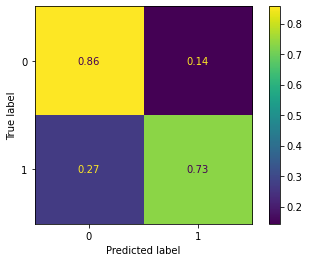

In [30]:
cm = confusion_matrix(baseline_y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.show()

### Bert Scores Accuracy

In [31]:
scores = np.array(bert_X_test[['bert_score_0', 'bert_score_1']])
y_pred = np.argmax(scores, axis=1)

accuracy = accuracy_score(bert_y_test, y_pred)
accuracy

0.7787197178305126

### Bert XGBoost Accuracy

In [32]:
from xgboost import XGBClassifier

# train
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(bert_X_train, bert_y_train)

# predict
y_pred = model.predict(bert_X_test)

accuracy = accuracy_score(bert_y_test, y_pred)
accuracy

0.7932304074750163

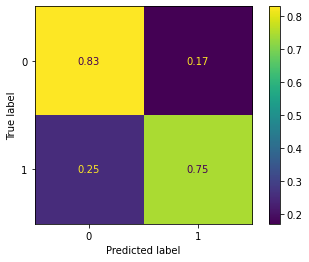

In [33]:
cm = confusion_matrix(bert_y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.show()

In [34]:
baseline_train.to_csv('baseline_train.csv', index=False)
baseline_test.to_csv('baseline_test.csv', index=False)
bert_train.to_csv('bert_train.csv', index=False)
bert_test.to_csv('bert_test.csv', index=False)

In [ ]:
df[df['node_text'] == 'Morally significant free will does not just require choice, but also a meaningful range of choices. Freedom to choose whether to donate $99 or $100 to charity is not significant. A range of possible actions - including evil ones - would need to be present in order for free will to be significant.']